<span style='font-family:serif'> <font size="7"> <span style='color:#0066cc'>**Mooring array examples and testings**

      
<span style='font-family:serif'> <font size="4.5"> Output must follow C-grid. Within output, there are two variables:
    
```python
diffX, diffY
```

<span style='font-family:serif'> <font size="4.5">  These are the differences between  mooring locations at centerpoints. By construction, 
<span style='font-family:serif'> <font size="4.5">their sum in absolute value should be equal to one at each location. This means that all locations
<span style='font-family:serif'> <font size="4.5"> moorings are equidistance from each other with unit distance.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec

import oceanspy as ospy
import dask
import copy as _copy

from oceanspy.llc_rearrange import mates, rotate_vars

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53278")
client

<Client: 'tcp://127.0.0.1:53278' processes=4 threads=8, memory=16.00 GiB>

In [4]:
# Directory
ECCO_url = "catalog_ECCO.yaml"
ECCOod = ospy.open_oceandataset.from_catalog("LLC", ECCO_url)
od = ECCOod

Opening LLC.


# Contruct some array in logical space

<span style='font-family:serif'> <font size="4.5"> The array spans multiple faces and reaches at edge of a face, without crossing into different face. I wrote code that can identify the adjacent face and sample velocity points (if necessary)

In [5]:
y0 = [k for k in range(45, 80)]
x0 = len(y0) * [40]
# face 1
y11 = [k for k in range(0, 11)]
x11 = [49+4*k for k in range(11)]

y12 = [k for k in range(11, 16)]
x12 = len(y12)*[89]

x13 = [k for k in range(45, 60)]
y13 = len(x13) * [25]

y14 = [k for k in range(25, 35)]
x14 = len(y14)*[89]

x15 = [k for k in range(45, 60)]
y15 = len(x15) * [45]

x16 = [k for k in range(70, 80)]
y16 = len(x16) * [89]

x17 = [k for k in range(80, 85)]
y17 = len(x17) * [79]

x1 = x11 + x12+ x13 + x14 + x15 + x16 + x17
y1 = y11 + y12+ y13 + y14 + y15 + y16 + y17

# face 4
x41 = [k for k in range(5, 46)]
y41 = len(x41) * [60]
y42 = [k for k in range(59, 10, -1)]
x42 = len(y42) * [45]
x4 = x41 + x42
y4 = y41 + y42

# face 3
y31 = [k for k in range(80, 40, -1)]
x31 = len(y31) * [60]
x32 = [k for k in range(60, 5, -1)]
y32 = len(x32) * [40]
x3 = x31 + x32
y3 = y31 + y32

# face 0 again!
x01 = [k for k in range(80, 45, -1)]
y01 = len(x01) * [45]

# get them all together
# cyclonic orientation
Xc, Yc = [x0, x1, x4, x3, x01], [y0, y1, y4, y3, y01]

# anticyclonic orientation -- clockwork
Xac = [x01[::-1], x3[::-1], x4[::-1], x1[::-1], x0[::-1]]
Yac = [y01[::-1], y3[::-1], y4[::-1], y1[::-1], y0[::-1]]

# faces
faces1 = [1, 2, 5, 4, 1]

print('faces1: ', faces1)


lonsc, latsc = [], []
lonsac, latsac = [], []
for i in range(len(Xc)):
    for j in range(len(Xc[i])):
        lonsc.append(od._ds['XC'].isel(face=faces1[i], X=Xc[i][j], Y=Yc[i][j]).squeeze().values)
        latsc.append(od._ds['YC'].isel(face=faces1[i], X=Xc[i][j], Y=Yc[i][j]).squeeze().values)


faces1:  [1, 2, 5, 4, 1]


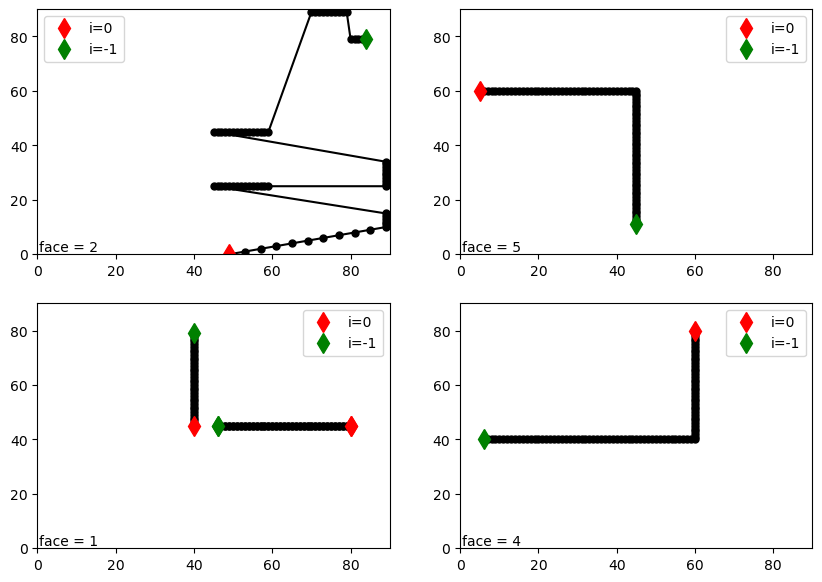

In [6]:
fig = plt.figure(figsize=(10, 7), facecolor='w')
gs = fig.add_gridspec(2, 2)

pos = [2, 0, 1, 3, 2]
fps = faces1

for i in range(1, len(Xc)):
    ax = fig.add_subplot(gs[pos[i]])
    plt.plot(np.array(Xc[i]), np.array(Yc[i]), 'k', marker='o', markersize=5)
    plt.plot(Xc[i][0], Yc[i][0], 'r', ls='', marker='d', markersize=10, label='i=0')
    plt.plot(Xc[i][-1], Yc[i][-1], 'g', ls='', marker='d', markersize=10, label='i=-1')
    plt.legend()
    ax.text(0.5, 1,  f'face = {fps[i]}')
    if i ==len(Xc)-1:
        plt.plot(np.array(Xc[i]), np.array(Yc[i]), 'k', marker='o', markersize=5)
        plt.plot(Xc[i][-1], Yc[i][-1], 'g', ls='', marker='d', markersize=10)
        plt.plot(Xc[i][0], Yc[i][0], 'r',ls='', marker='d', markersize=10)

        plt.plot(np.array(Xc[0]), np.array(Yc[0]), 'k', marker='o', markersize=5)
        plt.plot(Xc[0][-1], Yc[0][-1], 'g',ls='', marker='d', markersize=10)
        plt.plot(Xc[0][0], Yc[0][0], 'r',ls='', marker='d', markersize=10)
    plt.xlim([0, 90])
    plt.ylim(0, 90)

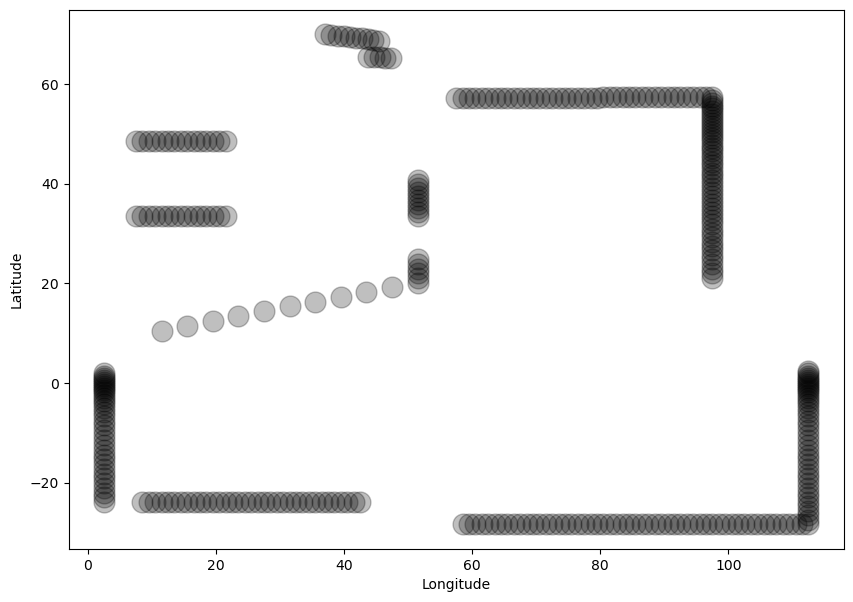

In [7]:
fig = plt.figure(figsize=(10, 7), facecolor='w')
plt.plot(lonsc, latsc, 'k', ls='', marker='o', markersize=15, alpha=0.25);
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
args = {
    'Xmoor': lonsc,
    'Ymoor': latsc,
    'serial': True,
}

In [9]:
client.restart()

<Client: 'tcp://127.0.0.1:53278' processes=0 threads=0, memory=0 B>

In [10]:
%%time
od_moor = od.subsample.mooring_array(**args)

Extracting mooring array


2023-11-02 17:32:10,488 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('xarray-k_p1-888ee0c16f187da334bd6520a273f604', 0),)
2023-11-02 17:32:10,716 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('xarray-PHrefC-3d5ece63bc408dc492022a06d06c3478', 0),)
2023-11-02 17:32:11,035 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('xarray-drF-249f2d6fb36d8b3f165bb5e5666601fa', 0),)
2023-11-02 17:32:11,038 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('xarray-drF-249f2d6fb36d8b3f165bb5e5666601fa', 0),)


CPU times: user 1.35 s, sys: 45.2 ms, total: 1.39 s
Wall time: 5.46 s


In [11]:
(abs(od_moor._ds['diffX'])+abs(od_moor._ds['diffY'])==1).values.all()

True

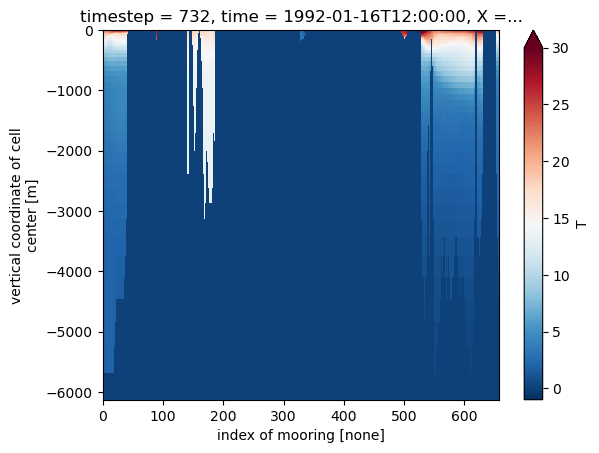

In [12]:
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

In [13]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values

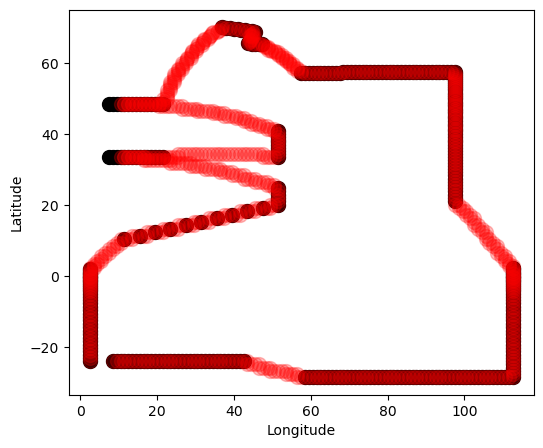

In [14]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lonsc, latsc, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r', ls='', marker='o', markersize=10, alpha=0.25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<span style='font-family:serif'> <font size="5.5"> testing c-grid layout for every mooring point.


In [15]:
dsf = od_moor._ds
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

In [16]:
client.restart()

<Client: 'tcp://127.0.0.1:53278' processes=0 threads=0, memory=0 B>

# another example, similar face topology

In [17]:
x10 = np.arange(80, 45, -1)
y10 = [25] * len(x10)

y11 = np.arange(30, 65)
x11 = [45] * len(y11)

x12 = np.arange(55, 80)
y12 = [75]*len(x12)

nx1 = np.array(list(x10) + list(x11) + list(x12))
ny1 = np.array(list(y10) + list(y11) + list(y12))

x20 = np.arange(10, 45)
y20 = [20] * len(x20)

y21 = np.arange(30, 75)
x21 = [55] * len(y21)

x22 = np.arange(45, 10, -1)
y22 = [80]*len(x22)

nx2 = np.array(list(x20) + list(x21) + list(x22))
ny2 = np.array(list(y20) + list(y21) + list(y22))

nX, nY = [nx1, nx2[::-1], nx1[:1]], [ny1, ny2[::-1], ny1[:1]]



nfaces = [2, 5, 2]

## reverse order
nXn, nYn = [nx2, nx1[::-1], nx2[:1]], [ny2, ny1[::-1], ny2[:1]]
nfacesn = [5, 2, 5]



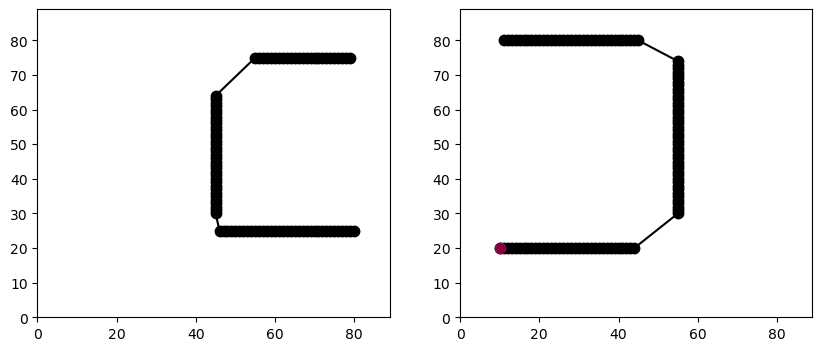

In [18]:
fig = plt.figure(figsize=(10, 4), facecolor='w')
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[1])
plt.plot(nXn[0], nYn[0], 'k', marker='o', markersize=7.5)
plt.plot(nXn[0][0], nYn[0][0], 'b', marker='o', markersize=7.5, alpha=0.5)

plt.plot(nXn[2], nYn[2], 'r', marker='o', markersize=7.5, alpha=0.5)

plt.xlim(0, 89)
plt.ylim(0, 89)
ax2 = fig.add_subplot(gs[0])
plt.plot(nXn[1], nYn[1], 'k', marker='o', markersize=7.5)
plt.xlim(0, 89)
plt.ylim(0, 89)
plt.show()

In [19]:
nlons, nlats = [], []
nlonsn, nlatsn = [], []
for i in range(len(nX)):
    for j in range(len(nX[i])):
        nlons.append(od._ds['XC'].isel(face=nfaces[i], X=nX[i][j], Y=nY[i][j]).squeeze().values)
        nlats.append(od._ds['YC'].isel(face=nfaces[i], X=nX[i][j], Y=nY[i][j]).squeeze().values)
    for j in range(len(nXn[i])):
        nlonsn.append(od._ds['XC'].isel(face=nfacesn[i], X=nXn[i][j], Y=nYn[i][j]).squeeze().values)
        nlatsn.append(od._ds['YC'].isel(face=nfacesn[i], X=nXn[i][j], Y=nYn[i][j]).squeeze().values)
        

## cyclonic orientation first

In [20]:
args = {
    'Xmoor': nlons,
    'Ymoor': nlats,
    'serial': True,
}

In [21]:
%%time
od_moor = od.subsample.mooring_array(**args)

Extracting mooring array
CPU times: user 455 ms, sys: 15.4 ms, total: 471 ms
Wall time: 2.48 s


In [22]:
(abs(od_moor._ds['diffX'])+abs(od_moor._ds['diffY'])==1).values.all()

True

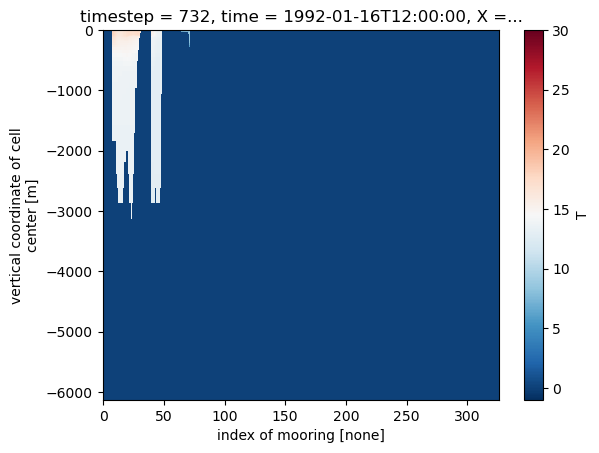

In [23]:
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

In [24]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values

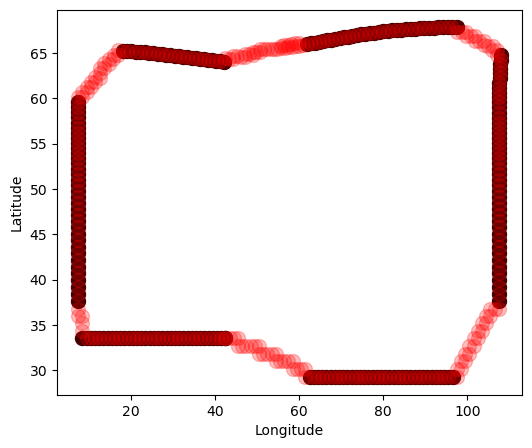

In [25]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(nlons, nlats, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r', ls='', marker='o', markersize=10, alpha=0.25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# testing c-grid layout

In [26]:
dsf = od_moor._ds
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

# antyclonic orientation now

In [27]:
args = {
    'Xmoor': nlonsn,
    'Ymoor': nlatsn,
    'serial': True,
}

In [28]:
%%time
od_moor = od.subsample.mooring_array(**args)

Extracting mooring array
CPU times: user 564 ms, sys: 24.5 ms, total: 588 ms
Wall time: 1.86 s


In [29]:
(abs(od_moor._ds['diffX'])+abs(od_moor._ds['diffY'])==1).values.all()

True

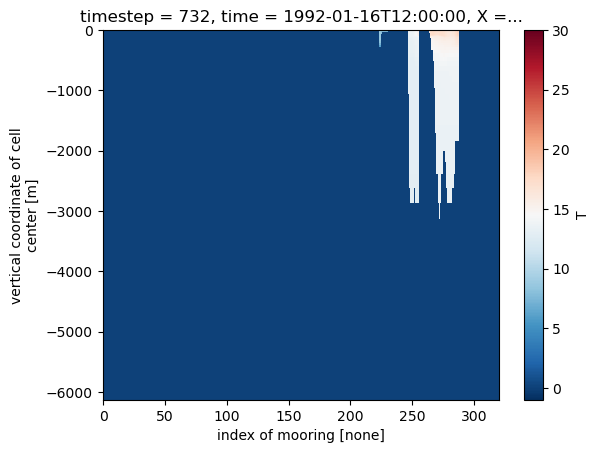

In [30]:
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

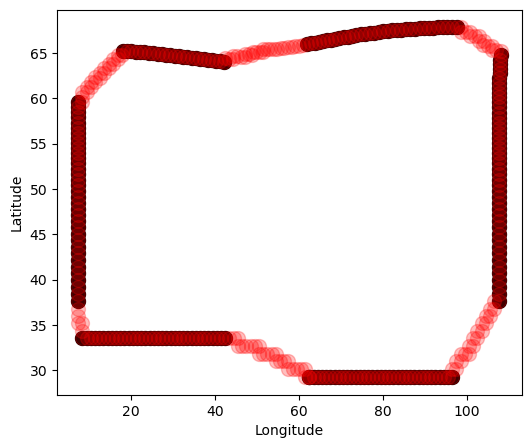

In [31]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(nlonsn, nlatsn, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r', ls='', marker='o', markersize=10, alpha=0.25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# testing c-grid layout

In [32]:
dsf = od_moor._ds
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

In [33]:
client.restart()

<Client: 'tcp://127.0.0.1:53278' processes=0 threads=0, memory=0 B>

# Now 4 faces with change in topology

In [34]:
x11 = np.arange(20, 69)
y11 = [20] * len(x11)
y12 = np.arange(21, 75)
x12 = [70] * len(y12)
x1 = np.array(list(x11) + list(x12))
y1 = np.array(list(y11) + list(y12))

x2 = np.arange(10, 80)
y2 = np.array([10]*len(x2))
x3 = np.arange(20, 75)
y3 = np.array([25] * len(x3))
y40 = np.arange(5, 25)
x40 = [60] * len(y40)
x41 = np.arange(60, 20, -1)
y41 = [30]*len(x41)
y42 = np.arange(20, 4, -1)
x42 = [20]*len(y42)
x4 = np.array(list(x40) + list(x41) + list(x42))
y4 = np.array(list(y40) + list(y41) + list(y42))
x5 = np.arange(60, 10, -1)
y5 = np.array([65]*len(x5))
x6 = np.arange(60, 10, -1)
y6 = np.array([80]*len(x6))
y7 = np.arange(85, 21, -1)
x7 = [19]*len(y7)

XX, YY = [x1, x2, x3, x4, x5, x6, x7], [y1, y2, y3, y4, y5, y6, y7]
xfaces = [10, 2, 5, 7, 5, 2, 10]

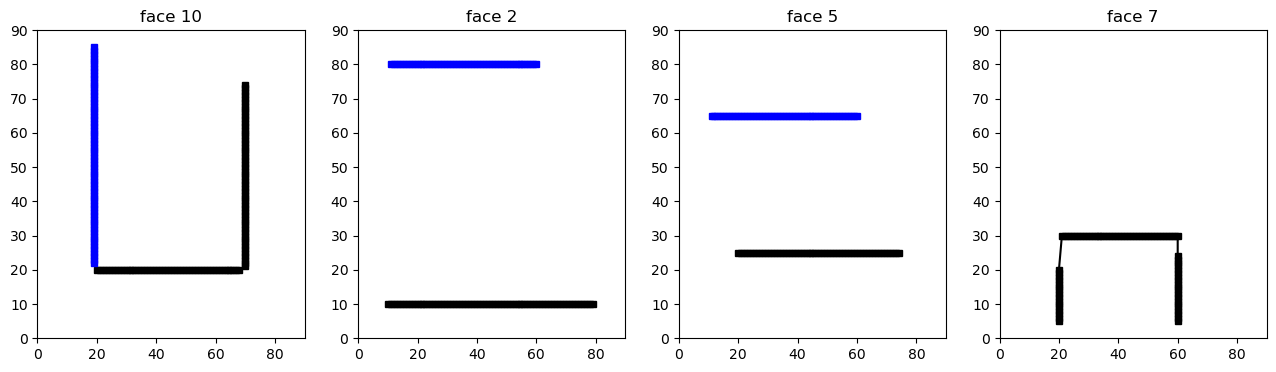

In [35]:
fig = plt.figure(figsize=(20, 4), facecolor='w')
gs = fig.add_gridspec(1, 5)

ax1 = fig.add_subplot(gs[0])
plt.plot(XX[0], YY[0],'k', marker='s', markersize=5)
plt.plot(XX[6], YY[6],'b', marker='s', markersize=5)
plt.xlim(0, 90); plt.ylim(0, 90)
plt.title('face '+str(xfaces[0]));

ax2 = fig.add_subplot(gs[1])
plt.plot(XX[1], YY[1],'k', marker='s', markersize=5)
plt.plot(XX[5], YY[5],'b', marker='s', markersize=5)

plt.xlim(0, 90); plt.ylim(0, 90)
plt.title('face '+str(xfaces[1]));

ax3 = fig.add_subplot(gs[2])
plt.plot(XX[2], YY[2],'k', marker='s', markersize=5)
plt.plot(XX[4], YY[4],'b', marker='s', markersize=5)

plt.xlim(0, 90); plt.ylim(0, 90)
plt.title('face '+str(xfaces[2]));


ax3 = fig.add_subplot(gs[3])
plt.plot(XX[3], YY[3],'k', marker='s', markersize=5)
plt.xlim(0, 90); plt.ylim(0, 90)
plt.title('face '+str(xfaces[3]));


# get coordinates

In [36]:
lonsx, latsx = [], []
for i in range(len(XX)):
    for j in range(len(XX[i])):
        lonsx.append(od._ds['XC'].isel(face=xfaces[i], X=XX[i][j], Y=YY[i][j]).squeeze().values)
        latsx.append(od._ds['YC'].isel(face=xfaces[i], X=XX[i][j], Y=YY[i][j]).squeeze().values)

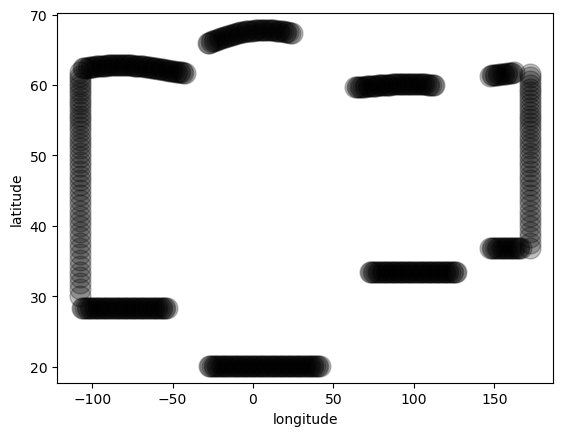

In [37]:
plt.plot(lonsx, latsx, 'k', ls='', marker='o', markersize=15, alpha=0.25)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [38]:
args = {
    'Xmoor': lonsx, 
    'Ymoor': latsx,
    'serial': True,
}

In [39]:
%%time
od_moor = od.subsample.mooring_array(**args)

Extracting mooring array
CPU times: user 1.94 s, sys: 89.5 ms, total: 2.03 s
Wall time: 9.26 s


In [40]:
(abs(od_moor._ds['diffX'])+abs(od_moor._ds['diffY'])==1).values.all()

True

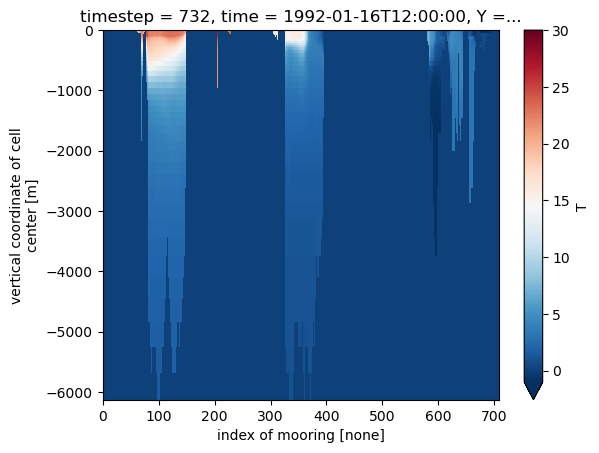

In [41]:
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

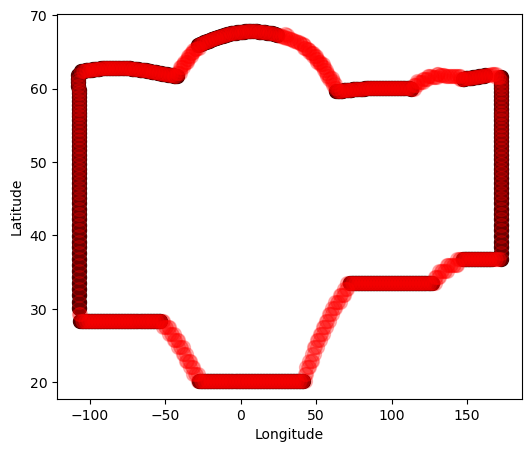

In [42]:
XC, YC = od_moor._ds['XC'].squeeze().values, od_moor._ds['YC'].squeeze().values
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lonsx, latsx, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r', ls='', marker='o', markersize=10, alpha=0.25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# testing c-grid layout

In [43]:
dsf = od_moor._ds
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

In [44]:
client.restart()

<Client: 'tcp://127.0.0.1:53278' processes=0 threads=0, memory=0 B>

# Construct an array from the Poseidon Viewer
<span style='font-family:serif'> <font size="5.5"> Output must follow C-grid.


In [45]:
pNA =[{"type":"LineString", "coordinates":[[-48.187388964014374,56.960906991890084],[-51.823752600378015,55.82892030263895],[-52.27829805492346,51.807741963874946],[-51.823752600378015,45.19480715870648],[-58.4146616912871,41.050173711875544],[-63.64193441855983,31.741690106513104],[-45.46011623674165,29.986012735834635],[-21.141934418559835,32.12744005725618],[-14.096479873105277,46.46165714016658],[-14.323752600377993, 57.57533124493861],[-25.914661691287087,60.83059571806558],[-39.55102532765074,60.15902944894782],[-47.96011623674165,56.960906991890084]]}] 
lon, lat = ospy.utils.viewer_to_range(pNA)

extracting LineString


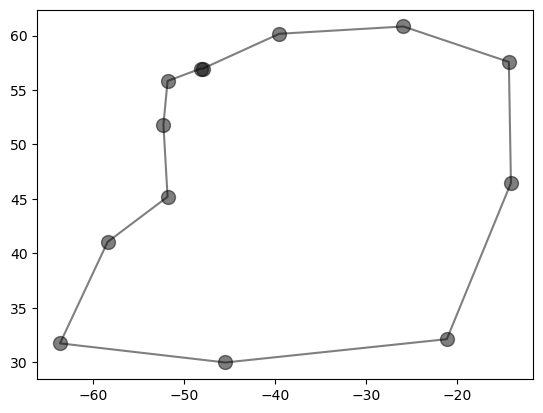

In [46]:
plt.plot(lon, lat, 'k', marker='o', markersize=10, alpha=0.5);

In [47]:
%%time
od_moor = od.subsample.mooring_array(Xmoor=lon, Ymoor=lat, serial=True)

Extracting mooring array
CPU times: user 779 ms, sys: 38.7 ms, total: 818 ms
Wall time: 5.4 s


In [48]:
DS_NA = od_moor._ds

In [49]:
XC, YC = od_moor['XC'].squeeze(), od_moor['YC'].squeeze()

In [50]:
(abs(od_moor['diffX'])+abs(od_moor['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

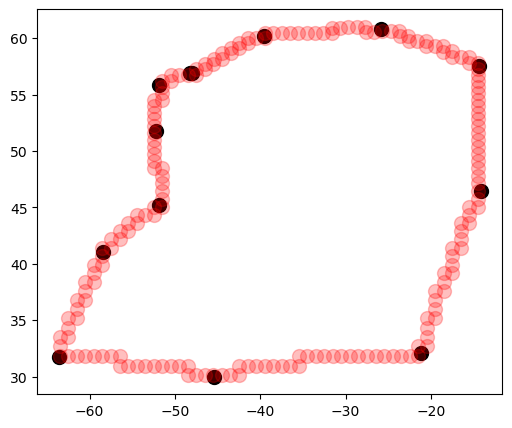

In [51]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lon, lat, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r',ls='', marker='o', markersize=10, alpha=0.25)
plt.show()

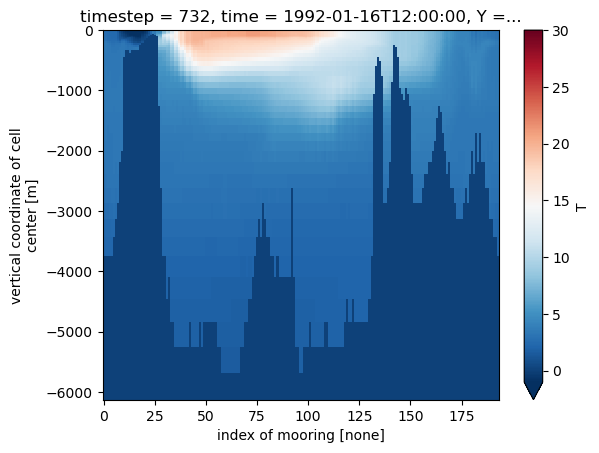

In [52]:
od_moor['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

In [53]:
dsf = od_moor._ds.persist()
_dim='mooring'

<span style='font-family:serif'> <font size="5.5"> testing c-grid layout for every mooring point.


In [54]:
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

# As before, but a little more complicated

<span style='font-family:serif'> <font size="5.5"> Output must follow C-grid.


In [55]:
pc = [{"type":"LineString","coordinates":[[-157.58510458895236,-49.929113472333654],[-158.3335453373931,-56.4180474136013],[-157.58510458895236,-66.9491001967596],[-127.64747465132241,-65.43909170451556],[-104.82003182387959,-66.9491001967596],[-76.75350375735152,-64.48901164230372],[-59.91358691743467,-59.9649368160756],[-49.06119606504382,-59.77709811839834],[-49.06119606504382,-67.09518612687597],[-40.82834783219558,-73.04637258315987],[-2.283649287497039,-67.38473350379634],[22.78911578526804,-66.05394012511698],[49.732982729134996,-63.504730811017126],[78.9221719183242,-62.311936937237796],[102.52851624436076,-61.26497563498257],[119.36843308427763,-59.222724692731425],[120.1168738327184,-52.52506277528884],[114.50356821941274,-45.9407502581646],[90.55346426930878,-41.340346963740906],[57.99629171213625,-37.88205039129804],[30.303984019828572,-37.5860952909328],[-17.222003506158956,-35.481526087073114],[-41.17210745626293,-43.549163986078796],[-53.147159431314876,-52.978067922480726],[-61.7542280383835,-56.43483466663744],[-70.73551701967247,-57.85575305946762],[-87.20121348536895,-51.371854559255056],[-81.21368749784294,-39.92040864793066],[-84.20745049160595,-22.77515385083268],[-106.6606729448284,1.2986691385364821],[-131.35921764337309,21.715726006363894],[-154.5608808450363,20.669007174659797],[-157.92886421301966,-8.400687880491319],[-169.90391618807166,-25.50672614934794],[-167.28437356852905,-39.05399570881964],[-157.55464383879928,-42.454492348945855],[-157.55464383879928,-50.427847608420734]]}]
lon, lat = ospy.utils.viewer_to_range(pc)

extracting LineString


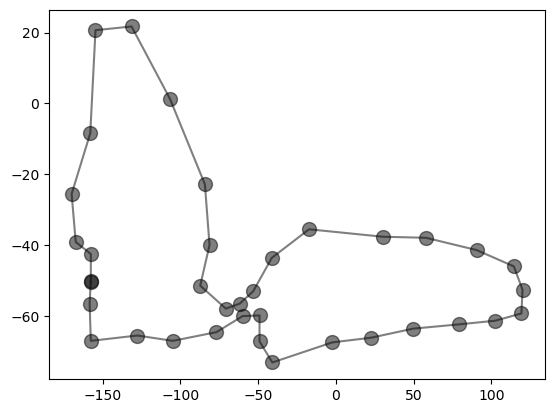

In [56]:
plt.plot(lon, lat, 'k', marker='o', markersize=10, alpha=0.5);

In [57]:
%%time
od_moor = od.subsample.mooring_array(Xmoor=lon, Ymoor=lat, serial=True)

Extracting mooring array
CPU times: user 2.75 s, sys: 100 ms, total: 2.85 s
Wall time: 7.87 s


In [58]:
XC, YC = od_moor._ds['XC'].squeeze(), od_moor._ds['YC'].squeeze()

In [59]:
(abs(od_moor._ds['diffX'])+abs(od_moor._ds['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

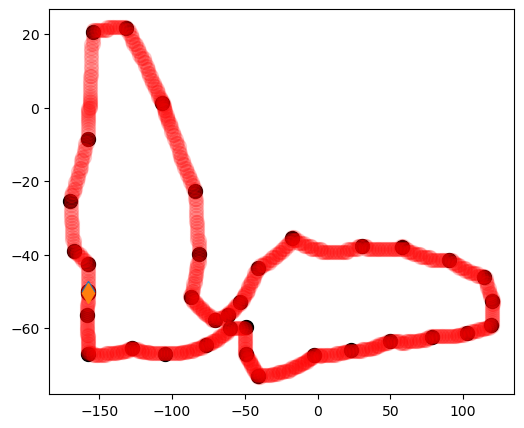

In [60]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lon, lat, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC, YC, 'r',ls='', marker='o', markersize=10, alpha=0.15)
plt.plot(XC[0], YC[0], marker='d', markersize=10)
plt.plot(XC[-1], YC[-1], marker='d', markersize=10)
plt.show()

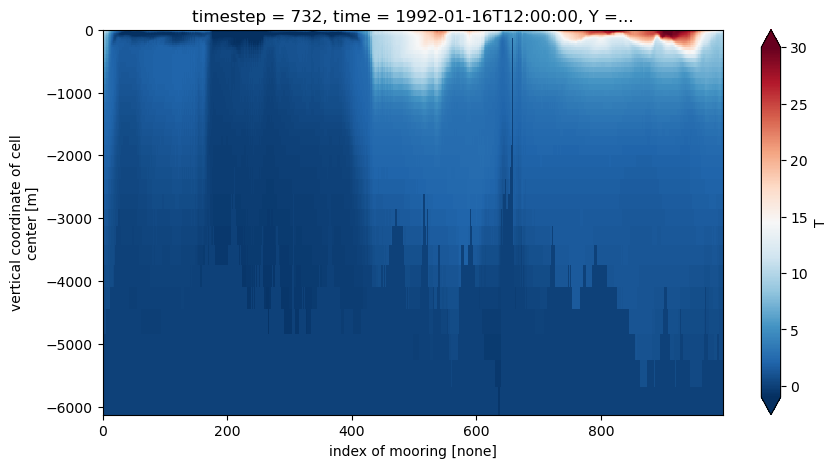

In [61]:
fig = plt.figure(figsize=(10, 5), facecolor='w')
od_moor._ds['T'].squeeze().plot(cmap='RdBu_r', vmin=-1, vmax=30)
plt.show()

In [62]:
dsf = od_moor._ds.persist()

In [63]:
_dim = "mooring"

<span style='font-family:serif'> <font size="5.5"> testing c-grid layout for every mooring point.


In [64]:
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim: m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

In [65]:
client.restart()

<Client: 'tcp://127.0.0.1:53278' processes=4 threads=8, memory=16.00 GiB>

# Arctic data

<span style='font-family:serif'> <font size="5.5"> Construct examples that span a region of the arctic and cross into a different face



In [66]:
# coordinate locations
lons76N = np.array([6.2, 97.8, -172.21623, -83.78377])
lats76N = 76 * np.ones(np.shape(lons76N))

lats_6E = np.array([10, 20, 30, 45, 60.131752, 65.39574, 70.104706, 74.43877, 78.69695, 82.68835])
lons6E = 6 * np.ones(np.shape(lats_6E))

lons90W = -87.5 * np.ones(np.shape(lats_6E))

lons170W = -170 * np.ones(np.shape(lats_6E))

# 76N
<span style='font-family:serif'> <font size="5.5"> First, entirely within the arctic. Crosses the jump in longitude values at |180| degrees.


In [67]:
%%time
od_moor76N = od.subsample.mooring_array(Xmoor=lons76N, Ymoor=lats76N, serial=True)

Extracting mooring array
CPU times: user 422 ms, sys: 16 ms, total: 438 ms
Wall time: 3.18 s


In [68]:
(abs(od_moor76N._ds['diffX'])+abs(od_moor76N._ds['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

In [69]:
XC76N, YC76N = od_moor76N._ds['XC'].squeeze(), od_moor76N._ds['YC'].squeeze()

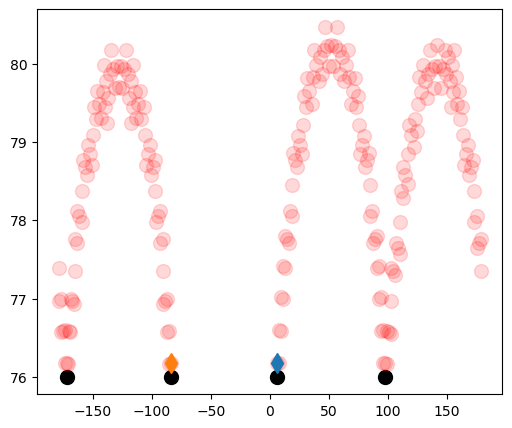

In [70]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lons76N, lats76N, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC76N, YC76N, 'r',ls='', marker='o', markersize=10, alpha=0.15)
plt.plot(XC76N[0], YC76N[0], marker='d', markersize=10)
plt.plot(XC76N[-1], YC76N[-1], marker='d', markersize=10)
# plt.ylim(72, 80)
plt.show()

<span style='font-family:serif'> <font size="5.5"> testing c-grid layout for every mooring point.


In [71]:
dsf = od_moor76N._ds.persist()
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', dsf.XG.isel(**xargs0).values)

x [178.36102 178.08281]
x [178.6211  178.36102]


# 6E

<span style='font-family:serif'> <font size="5.5"> Along the 6E longitude line. 


In [72]:
%%time
od_moor6E = od.subsample.mooring_array(Xmoor=lons6E, Ymoor=lats_6E, serial=True)

Extracting mooring array
CPU times: user 555 ms, sys: 37 ms, total: 592 ms
Wall time: 2.66 s


In [73]:
(abs(od_moor6E._ds['diffX'])+abs(od_moor6E._ds['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

In [74]:
XC6E, YC6E = od_moor6E._ds['XC'].squeeze(), od_moor6E._ds['YC'].squeeze()

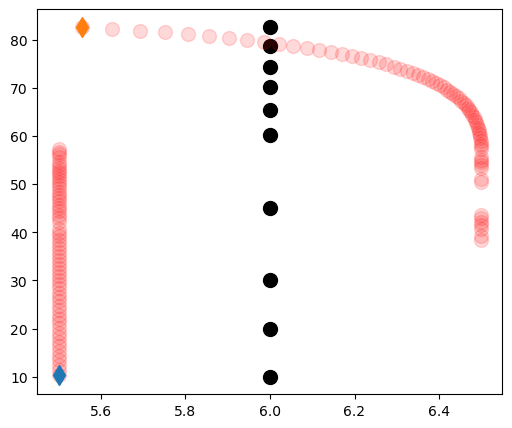

In [75]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lons6E, lats_6E, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC6E, YC6E, 'r',ls='', marker='o', markersize=10, alpha=0.15)
plt.plot(XC6E[0], YC6E[0], marker='d', markersize=10)
plt.plot(XC6E[-1], YC6E[-1], marker='d', markersize=10)
# plt.ylim(72, 80)
plt.show()

<span style='font-family:serif'> <font size="5.5"> testing c-grid layout for every mooring point.


In [76]:
dsf = od_moor6E._ds.persist()
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

# 90W
<span style='font-family:serif'> <font size="5.5"> Along the 90W longitude line. 


In [77]:
%%time
od_moor90W = od.subsample.mooring_array(Xmoor=lons90W, Ymoor=lats_6E, serial=True)

Extracting mooring array
CPU times: user 516 ms, sys: 21.8 ms, total: 537 ms
Wall time: 1.19 s


In [78]:
(abs(od_moor90W._ds['diffX'])+abs(od_moor90W._ds['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

In [79]:
XC90W, YC90W = od_moor90W._ds['XC'].squeeze(), od_moor90W._ds['YC'].squeeze()

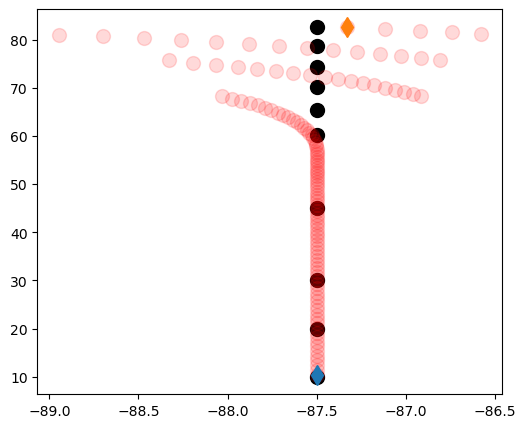

In [80]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lons90W, lats_6E, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC90W, YC90W, 'r',ls='', marker='o', markersize=10, alpha=0.15)
plt.plot(XC90W[0], YC90W[0], marker='d', markersize=10)
plt.plot(XC90W[-1], YC90W[-1], marker='d', markersize=10)
# plt.ylim(72, 80)
plt.show()

<span style='font-family:serif'> <font size="5.5"> testing c-grid


In [81]:
dsf = od_moor90W._ds.persist()
_dim='mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

# 170W
<span style='font-family:serif'> <font size="5.5"> Along the 170 longitude line.


In [82]:
%%time
od_moor170W = od.subsample.mooring_array(Xmoor=lons170W, Ymoor=lats_6E, serial=True)

Extracting mooring array
CPU times: user 529 ms, sys: 20.2 ms, total: 549 ms
Wall time: 1.19 s


In [83]:
(abs(od_moor170W._ds['diffX'])+abs(od_moor170W._ds['diffY'])==1).all()

<xarray.DataArray ()>
array(True)

In [84]:
XC170W, YC170W = od_moor170W._ds['XC'].squeeze(), od_moor170W._ds['YC'].squeeze()

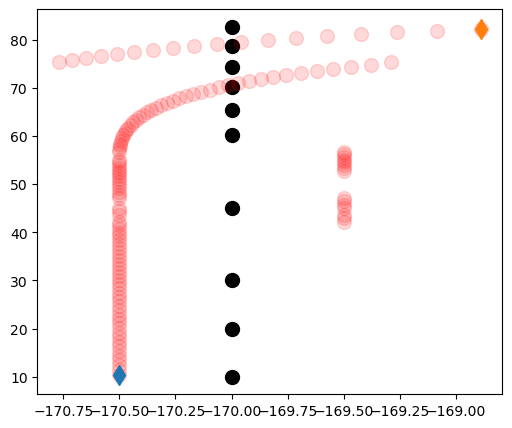

In [85]:
fig = plt.figure(figsize=(6, 5), facecolor='w')
plt.plot(lons170W, lats_6E, 'k', ls='', lw=2, marker='o', markersize=10)
plt.plot(XC170W, YC170W, 'r',ls='', marker='o', markersize=10, alpha=0.15)
plt.plot(XC170W[0], YC170W[0], marker='d', markersize=10)
plt.plot(XC170W[-1], YC170W[-1], marker='d', markersize=10)
# plt.ylim(72, 80)
plt.show()

<span style='font-family:serif'> <font size="5.5"> testing c-grid


In [86]:
dsf = od_moor170W._ds.persist()
_dim = 'mooring'
for m in range(len(dsf[_dim])):
    yargs0 = {'Yp1':0, _dim: m}
    yargs1 = {'Yp1':1, _dim: m}
    xargs0 = {'Xp1':0, _dim: m}
    xargs1 = {'Xp1':1, _dim:m}
    if not (dsf.YG.isel(**yargs0).values < dsf.YG.isel(**yargs1).values).flatten().all():
        print('y', m)
    if not (dsf.XG.isel(**xargs0).values < dsf.XG.isel(**xargs1).values).flatten().all():
        print('x', m)

In [87]:
client.close()